![XKCD data pipeline](https://imgs.xkcd.com/comics/data_pipeline.png)

[https://xkcd.com/2054](https://xkcd.com/2054/)

In [30]:
from datetime import datetime

min_lat, max_lat = 20, 30
min_lon, max_lon = -82, -97
bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

# Temporal range of 1 week.
start = datetime(2018, 10, 15, 0, 0, 0)
stop = datetime(2018, 10, 22, 0, 0, 0)

# Sea surface temperature CF names.
cf_names = ['sea_water_temperature',
            'sea_surface_temperature',
            'sea_water_potential_temperature',
            'equivalent_potential_temperature',
            'sea_water_conservative_temperature',
            'pseudo_equivalent_potential_temperature']

In [31]:
def fes_date_filter(start, stop, constraint='overlaps'):
    from owslib import fes
    start = start.strftime('%Y-%m-%d %H:00')
    stop = stop.strftime('%Y-%m-%d %H:00')
    if constraint == 'overlaps':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                                literal=stop)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                 literal=start)
    elif constraint == 'within':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                   literal=start)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                              literal=stop)
    else:
        raise NameError('Unrecognized constraint {}'.format(constraint))
    return begin, end

In [32]:
from owslib import fes

kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)

filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)]),
        ]
    )
]

In [33]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty
    # Iterate over sorted results.
    sortby = SortBy([SortProperty('dc:title', 'ASC')])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, 'results', 1)
    while nextrecord != 0:
        csw.getrecords2(constraints=filter_list, startposition=startposition,
                        maxrecords=pagesize, sortby=sortby)
        csw_records.update(csw.records)
        if csw.results['nextrecord'] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [34]:
from owslib.csw import CatalogueServiceWeb


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 234 records.



In [35]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n{}\n'.format(value.title, key))

[West Florida Central Buoy]
data.gcoos.org:8080-urn_ioos_station_comps_c12

[West Florida Shelf FVCOM (WFCOM)]
edu.usf:fvcom

[West Florida South Buoy]
data.gcoos.org:8080-urn_ioos_station_comps_c13

[WEST GULF - 207 NM East of Brownsville, TX]
sdf.ndbc.noaa.gov-urn_ioos_station_wmo_42002

[42002 - W GULF 207 NM East of Brownsville, TX]
data.gcoos.org:8080-urn_ioos_station_ndbc_42002

[42003 East GULF - 208 NM West of Naples, FL]
wmo_42003

[42003 - E GULF 262 nm South of Panama City, FL]
data.gcoos.org:8080-urn_ioos_station_ndbc_42003

[* 42013 - C10 - WFS Central Buoy, 25m Isobath]
edu_usf_marine_comps_c10

[42013 - C10 - WFS Central Buoy, 25m Isobath - sea_water_temperature]
edu.usf.marine.comps:c10:sea_water_temperature

[42019 - Freeport, TX 60 NM South of Freeport, TX]
data.gcoos.org:8080-urn_ioos_station_ndbc_42019

[42020 - Corpus Christi, TX 50NM Southeast of Corpus Christi, TX]
data.gcoos.org:8080-urn_ioos_station_ndbc_42020

[* 42022 - C12 - WFS Central Buoy, 50m Isobath]
ed

In [36]:
import textwrap


key, value = list(csw.records.items())[-1]

# print('\n'.join(textwrap.wrap(value.abstract)))
value.abstract

"Timeseries data from '(VENF1) Venice, FL' (urn:ioos:station:wmo:VENF1)"

In [37]:
print('\n'.join(value.subjects))

earth science
atmosphere
ocean
biosphere
biology
environment
NOAA National Data Buoy Center NDBC
time
latitude
longitude
wind_speed
air_pressure
wind_from_direction
sea_water_temperature
wind_speed_of_gust
air_temperature
dew_point_temperature
depth
geoscientificInformation


In [38]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

geolink: WWW:LINK
scheme: order
URL: http://erddap.secoora.org/erddap/tabledap/wmo_venf1.html

geolink: None
scheme: order
URL: http://erddap.secoora.org/erddap/tabledap/wmo_venf1.graph

geolink: None
scheme: .html
URL: http://erddap.secoora.org/erddap/tabledap/wmo_venf1

geolink: None
scheme: .html
URL: http://erddap.secoora.org/erddap/tabledap/wmo_venf1



In [39]:
fmt = ('http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
       'service=SOS&'
       'eventTime={0:%Y-%m-%dT00:00:00}/{1:%Y-%m-%dT00:00:00}&'
       'observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&'
       'version=1.0.0&'
       f'request=GetObservation&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8771450&'
       'responseFormat=text/csv')

url = fmt.format(start, stop)
url

'http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&eventTime=2018-10-15T00:00:00/2018-10-22T00:00:00&observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&version=1.0.0&request=GetObservation&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8771450&responseFormat=text/csv'

In [40]:
import pandas as pd

df = pd.read_csv(
    url,
    index_col='date_time', parse_dates=True
)

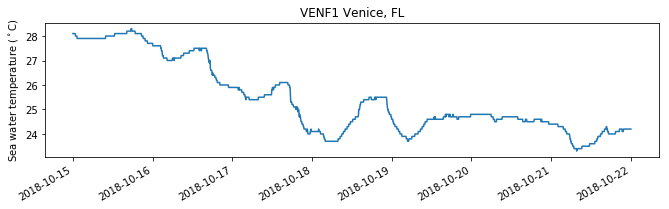

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(11, 2.75))
ax = df['sea_water_temperature (C)'].plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel(r'Sea water temperature ($^\circ$C)')
ax.set_title(value.title);